# Prediksi Emisi Tambang — Clean & Beginner-Friendly Notebook




# 1) Imports

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, HuberRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import loguniform
import joblib
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
sns.set(style='whitegrid')

# 2) Configure path & load data

In [2]:
DATA_PATH = '/content/dataset_emisi_tambang_5000_hackthon.csv'
TARGET = 'emisi_CO2e'

df = pd.read_csv(DATA_PATH)
print('Data shape:', df.shape)
df.head()


Data shape: (5000, 6)


,produksi_ton,solar_liter,listrik_kWh,jam_operasi,alat_berat,emisi_CO2e
0,16524.0,7009.0,30616.0,474.0,20.0,25807.0
1,9800.0,4117.0,20284.0,477.0,12.0,16890.0
2,18752.0,7132.0,25472.0,460.0,23.0,28520.0
3,19703.0,9711.0,33779.0,435.0,24.0,32560.0
4,5245.0,2483.0,10745.0,433.0,6.0,9531.0


# 3) EDA

In [3]:
print('\nMissing percentage per column:')
print((df.isna().mean()*100).round(2))

print('\nNumeric summary:')
display(df.describe().T)


Missing percentage per column:
produksi_ton    4.90
solar_liter     5.22
listrik_kWh     4.62
jam_operasi     4.76
alat_berat      5.12
emisi_CO2e      5.40
dtype: float64

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
produksi_ton,4755.0,14899.451945,4965.589983,3000.0,11524.5,14949.0,18145.5,30000.0
solar_liter,4739.0,6693.115003,2700.780251,628.0,4774.0,6480.0,8365.0,18933.0
listrik_kWh,4769.0,26797.893059,10099.297841,4092.0,19849.0,26177.0,32783.0,78193.0
jam_operasi,4762.0,404.269425,80.000611,200.0,349.0,404.0,459.0,656.0
alat_berat,4744.0,18.156830,6.144224,5.0,14.0,18.0,22.0,37.0
emisi_CO2e,4730.0,24446.231924,7897.062158,4518.0,19146.0,24352.0,29457.5,55039.0


<Figure size 1200x800 with 0 Axes>

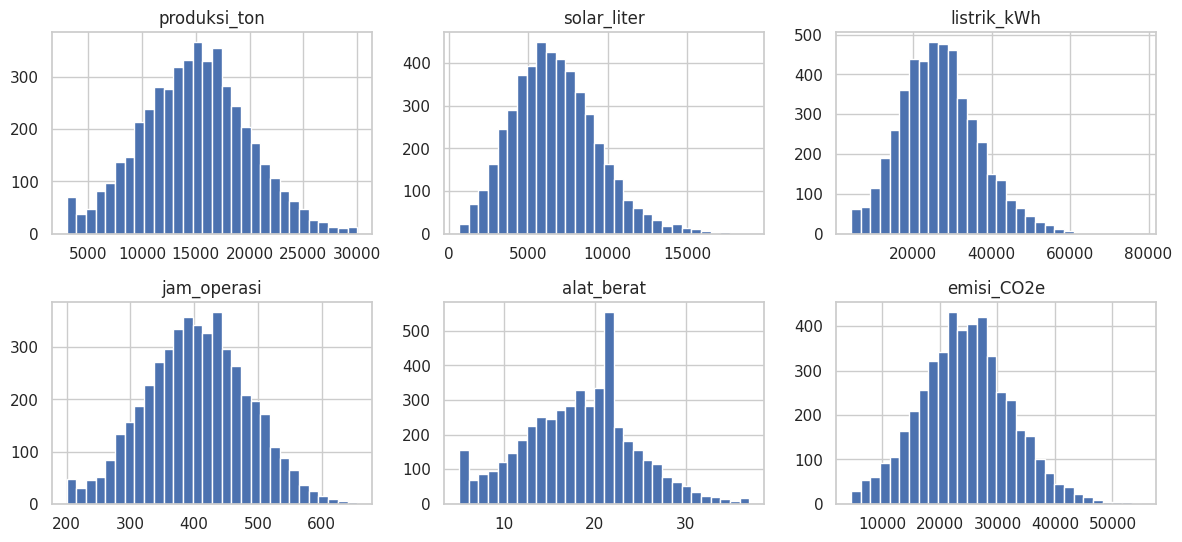

In [4]:
numeric_cols = df.columns

plt.figure(figsize=(12, 8))
df.hist(bins=30, figsize=(12, 8), layout=(3, 3))
plt.tight_layout()
plt.show()

### Tentukan fitur numerik yang biasa dipakai di dataset emisi

### Korelasi sederhana

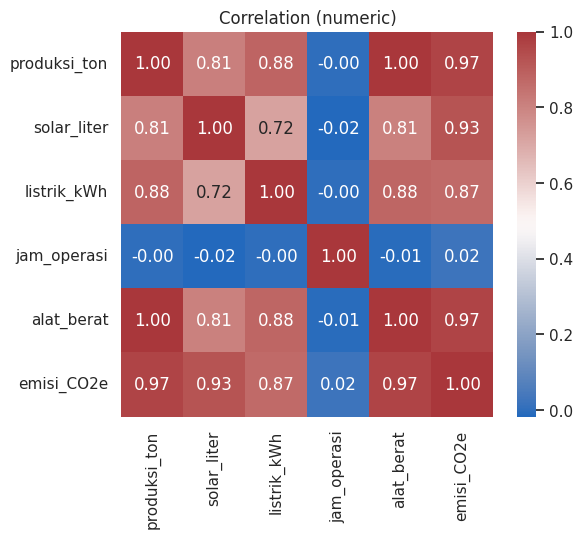

In [5]:

plt.figure(figsize=(6,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='vlag')
plt.title('Correlation (numeric)')
plt.show()

In [6]:
numeric_features = ['produksi_ton','solar_liter','listrik_kWh']
categorical_features = []
print('\nNumeric features:', numeric_features)
print('Categorical features:', categorical_features)


Numeric features: ['produksi_ton', 'solar_liter', 'listrik_kWh']
Categorical features: []


# 4) Prepare data (drop rows with missing target, split)

In [7]:
df = df.dropna(subset=[TARGET]).reset_index(drop=True)
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (3784, 5) Test shape: (946, 5)


# 5) Simple preprocessor: impute numeric with median + robust scaling; categorical -> most frequent

In [8]:
num_pipe = Pipeline([('impute', SimpleImputer(strategy='median')), ("scale", RobustScaler())])
cat_pipe = Pipeline([('impute', SimpleImputer(strategy='most_frequent')), ("encode", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))])

preprocessor = ColumnTransformer([('num', num_pipe, numeric_features), ('cat', cat_pipe, categorical_features)])

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', RobustScaler())]),
                                 ['produksi_ton', 'solar_liter',
                                  'listrik_kWh']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 [])])

# 6) build pipeline, evaluate function

In [9]:
def make_pipeline(model):
    return Pipeline([('preproc', preprocessor), ('model', model)])


def evaluate(pipe, X_train, y_train, X_test, y_test):
    y_pred_tr = pipe.predict(X_train)
    y_pred_te = pipe.predict(X_test)
    return {
        'r2_train': r2_score(y_train, y_pred_tr),
        'r2_test': r2_score(y_test, y_pred_te),
        'mae_train': mean_absolute_error(y_train, y_pred_tr),
        'mae_test': mean_absolute_error(y_test, y_pred_te),
        'rmse_train': np.sqrt(mean_squared_error(y_train, y_pred_tr)),
        'rmse_test': np.sqrt(mean_squared_error(y_test, y_pred_te))
    }

# 7) Baseline models: fit & evaluate

In [10]:
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(max_iter=5000),
    'Huber': HuberRegressor()
}

baseline_results = []
trained_pipes = {}
for name, m in models.items():
    p = make_pipeline(m)
    p.fit(X_train, y_train)
    trained_pipes[name] = p
    res = evaluate(p, X_train, y_train, X_test, y_test)
    res['model'] = name
    baseline_results.append(res)

baseline_df = pd.DataFrame(baseline_results).sort_values('r2_test', ascending=False).reset_index(drop=True)
baseline_df

,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test,model
0,0.974046,0.969659,732.418238,780.970902,1274.287988,1365.720282,Linear
1,0.974046,0.969653,732.620480,781.274896,1274.291159,1365.863834,Ridge
2,0.972969,0.969101,694.917816,734.920662,1300.446029,1378.224680,Huber
3,0.906488,0.900816,1840.761639,1863.207317,2418.793555,2469.275473,ElasticNet


# 8) Lightweight tuning for a couple models

In [25]:
param_spaces = {
    'Ridge': {'model__alpha': loguniform(1e-3, 10)},
    'ElasticNet': {'model__alpha': loguniform(1e-4, 1), 'model__l1_ratio': [0.1,0.2,0.5]}
}

best_models = {}
for name, space in param_spaces.items():
    print('Tuning', name)
    base = globals()[name]()
    pipe = make_pipeline(base)
    rs = RandomizedSearchCV(pipe, param_distributions=space, n_iter=8, cv=4, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1, verbose=0)
    rs.fit(X_train, y_train)
    print(' Best params:', rs.best_params_)
    best_models[name] = rs.best_estimator_

best_models

Tuning Ridge
 Best params: {'model__alpha': np.float64(0.0017073967431528124)}
Tuning ElasticNet
 Best params: {'model__alpha': np.float64(0.00012087541473056971), 'model__l1_ratio': 0.2}


{'Ridge': Pipeline(steps=[('preproc',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('impute',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scale',
                                                                    RobustScaler())]),
                                                   ['produksi_ton',
                                                    'solar_liter',
                                                    'listrik_kWh']),
                                                  ('cat',
                                                   Pipeline(steps=[('impute',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('encode',
                               

# 9) Build a simple stacking ensemble (use tuned models if available)

In [12]:
estimators = []
if 'Ridge' in best_models:
    estimators.append(('ridge', best_models['Ridge'].named_steps['model']))
else:
    estimators.append(('ridge', Ridge()))

if 'ElasticNet' in best_models:
    estimators.append(('elastic', best_models['ElasticNet'].named_steps['model']))
else:
    estimators.append(('elastic', ElasticNet(max_iter=5000)))


estimators.append(('hgb', HistGradientBoostingRegressor(max_iter=200, random_state=42)))

stack = StackingRegressor(estimators=estimators, final_estimator=Ridge(), passthrough=False, n_jobs=-1)
stack_pipe = make_pipeline(stack)
stack_pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['produksi_ton',
                                                   'solar_liter',
                                                   'listrik_kWh']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('model',
                 StackingRegressor(estimators=[('ridge',
                                                Ridge(alpha=np.float64(0.0017073967431528124))),
                                               ('elastic',
                                                ElasticNet(alpha=np.float64(0.00012087541473056971),
                                                           l1_ratio=0.2)),
                                               ('hgb',
                                                HistGradientBoostingRegressor(max_iter=200,
                                                                              random_state=42))],
                                   final_estimator=Ridge(), n_jobs=-1))])

# 10) Evaluate stacking + combine results for comparison

In [13]:
stack_res = evaluate(stack_pipe, X_train, y_train, X_test, y_test)
stack_res['model'] = 'Stacking'

all_results = baseline_df.copy()
all_results = pd.concat([all_results, pd.DataFrame([stack_res])], ignore_index=True)
all_results = all_results.sort_values('r2_test', ascending=False).reset_index(drop=True)
display(all_results)

,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test,model
0,0.992917,0.983663,459.972017,650.542494,665.696874,1002.160632,Stacking
1,0.974046,0.969659,732.418238,780.970902,1274.287988,1365.720282,Linear
2,0.974046,0.969653,732.620480,781.274896,1274.291159,1365.863834,Ridge
3,0.972969,0.969101,694.917816,734.920662,1300.446029,1378.224680,Huber
4,0.906488,0.900816,1840.761639,1863.207317,2418.793555,2469.275473,ElasticNet


# 11) Simple comparison plots (R2, MAE, RMSE)

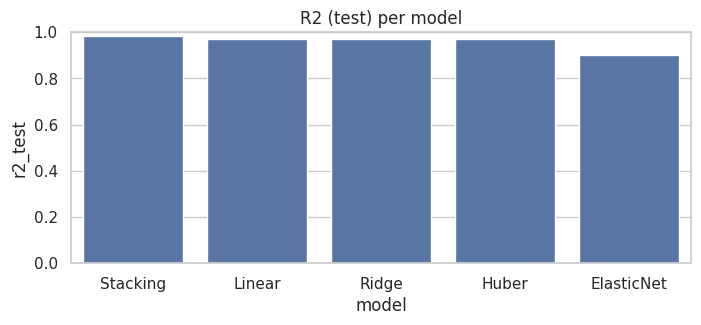

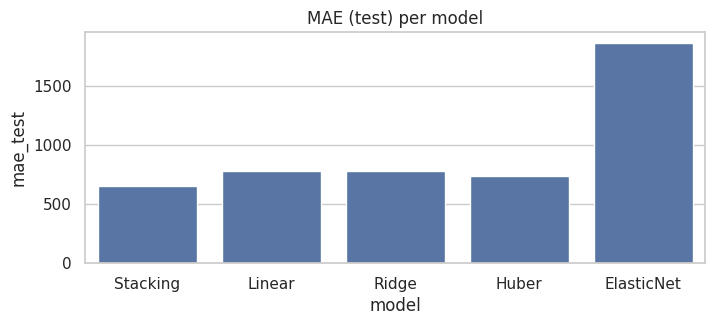

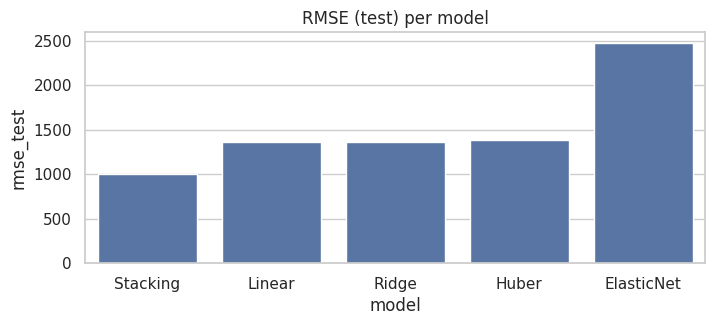

In [14]:
plt.figure(figsize=(8,3))
sns.barplot(data=all_results, x='model', y='r2_test'); plt.title('R2 (test) per model'); plt.ylim(0,1); plt.show()

plt.figure(figsize=(8,3))
sns.barplot(data=all_results, x='model', y='mae_test'); plt.title('MAE (test) per model'); plt.show()

plt.figure(figsize=(8,3))
sns.barplot(data=all_results, x='model', y='rmse_test'); plt.title('RMSE (test) per model'); plt.show()

# 12) Actual vs Predicted & Residuals for stacking

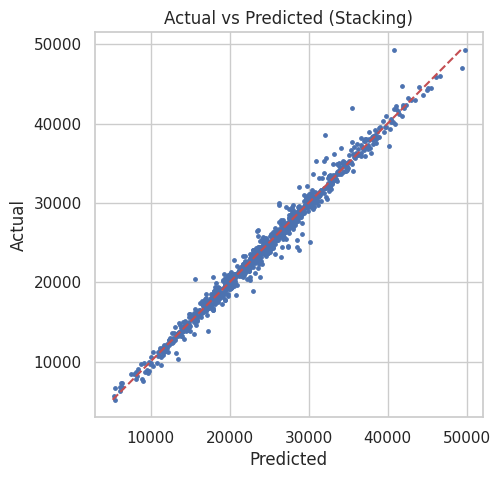

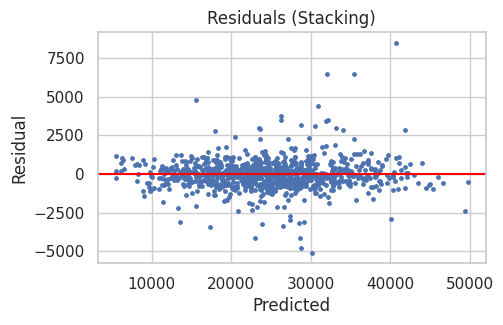

In [15]:
yp = stack_pipe.predict(X_test)
plt.figure(figsize=(5,5)); plt.scatter(yp, y_test, s=6); plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Actual vs Predicted (Stacking)'); plt.show()

res = y_test - yp
plt.figure(figsize=(5,3)); plt.scatter(yp, res, s=6); plt.axhline(0, color='red'); plt.xlabel('Predicted'); plt.ylabel('Residual'); plt.title('Residuals (Stacking)'); plt.show()


# 13) Cross validation for stacking model

In [16]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(stack_pipe, X, y, cv=cv, scoring='r2')

cv_table = pd.DataFrame({
    "Fold": [1, 2, 3, 4, 5],
    "R2 Score": scores
})

cv_summary = pd.DataFrame({
    "Mean R2": [scores.mean()],
})

print("=== Cross Validation Table ===")
display(cv_table)

=== Cross Validation Table ===


,Fold,R2 Score
0,1,0.983690
1,2,0.986085
2,3,0.987803
3,4,0.985926
4,5,0.987002


In [17]:
models = {
    'Linear': trained_pipes['Linear'],
    'Ridge': trained_pipes['Ridge'],
    'ElasticNet': trained_pipes['ElasticNet'],
    'Huber': trained_pipes['Huber'],
    'Stacking': stack_pipe
}

cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    cv_results.append({
        "Model": name,
        "Mean R2": scores.mean(),
        "Std Dev": scores.std()
    })

cv_results_df = pd.DataFrame(cv_results).sort_values("Mean R2", ascending=False)
cv_results_df

,Model,Mean R2,Std Dev
4,Stacking,0.986101,0.001382
1,Ridge,0.972835,0.003533
0,Linear,0.972833,0.003537
3,Huber,0.971942,0.004066
2,ElasticNet,0.905708,0.004148



# 14) Save best model and results

In [18]:
joblib.dump(stack_pipe, 'clean_best_stacking.pkl')

Saved clean_best_stacking.pkl and clean_model_comparison.csv
